In [3]:
from preprocess_data import Custom_Dataset, ChannelMNISTDataset
from torch.utils.data import DataLoader
import torch
from model import BaseConvModel, ProtoModel, FinalLayer, WholeModel, exp_var_dict

from push_prototypes import push
import h5py
from receptive_field import compute_rf, output_to_input
import matplotlib.pyplot as plt
import numpy as np
import argparse
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.optim.lr_scheduler as lr_scheduler
from torchgeo_euro import EuroSAT, ScaleAndNormalize
from torchvision.transforms import v2 as transforms

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pickle

import statistics
from statistics import mode

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns


In [4]:
if torch.cuda.is_available():
    torch.set_default_device('cuda')
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    device = torch.device('cuda')
    print("GPU is set as the default device.")
else:
    print("CUDA is not available. CPU will be used as the default device.")
    device = 'cpu'

GPU is set as the default device.


/users/anaray34/.local/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [ ]:
prototype_info = 'data/models/mnist_models/mnist_prototype_info'
model_name = 'data/models/mnist_models/mnist_model.pth'

In [6]:
exp_dataset = exp_var_dict['exp_dataset']
whole = WholeModel(exp_dataset, exp_var_dict['num_channels'])
whole.load_state_dict(torch.load(model_name))
with open(prototype_info, "rb") as fp:  
    prototype_info_list = pickle.load(fp)

In [7]:
input_size = (32, 1, 56, 56)
chan_rf = []

for chan in range(exp_var_dict['num_channels']):
    imin_chan, imax_chan, jmin_chan, jmax_chan = compute_rf(whole.base_list[0], whole.proto_list[chan],input_size, prototype_info_list[chan][-1])
    chan_rf.append([imin_chan, imax_chan, jmin_chan, jmax_chan])

GPU is set as the default device.
GPU is set as the default device.
GPU is set as the default device.


In [ ]:

train_data = ChannelMNISTDataset(hdf5_data_file='data/syntheticMNIST/synthetic_data_channelmnist.hdf5', im_name='train_images',label_name='train_labels')
val_data = ChannelMNISTDataset(hdf5_data_file='data/syntheticMNIST/synthetic_data_channelmnist.hdf5', im_name='val_images',label_name='val_labels')
test_data = ChannelMNISTDataset(hdf5_data_file='data/syntheticMNIST/synthetic_data_channelmnist.hdf5', im_name='test_images',label_name='test_labels')

with h5py.File("data/syntheticMNIST/synthetic_data_channelmnist.hdf5",'r') as f:
    all_images = f['train_images'][:]
    all_labels = f['train_labels'][:]
    test_images = f['test_images'][:]
    test_labels = f['test_labels'][:]
    

train_dataloader = DataLoader(train_data, batch_size = exp_var_dict['batch_size'])
val_dataloader = DataLoader(val_data)
test_dataloader = DataLoader(test_data, shuffle=False)

push_dataloader = DataLoader(train_data, batch_size = len(all_images), shuffle=False)
print(len(train_data))
print(len(val_data))
print(len(test_data))

print(np.unique(test_labels, return_counts=True))


8640
2160
1200
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([131, 123, 122, 126, 106, 112, 109, 119, 126, 126]))


/users/anaray34/.local/lib/python3.11/site-packages/torch/utils/_device.py:77: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return func(*args, **kwargs)


Testing accuracy: 0.9783333333333334


"\nall_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes']))\ncorrect_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes'])) \ncorrect1_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes'])) \nsecond_correct_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes']))\nthird_correct_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes']))\nincorrect_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes']))\n\nfor q in range(len(test_images)):\n    pred_lab = pred_label[q]\n    weights = whole.final_list[0].last_layer.weight.cpu().detach().numpy()\n    sim_values = all_max_sims[q,:,:].reshape(exp_var_dict['num_channels']*exp_var_dict['num_prototypes'])\n    scores = sim_values * weights[pred_lab,

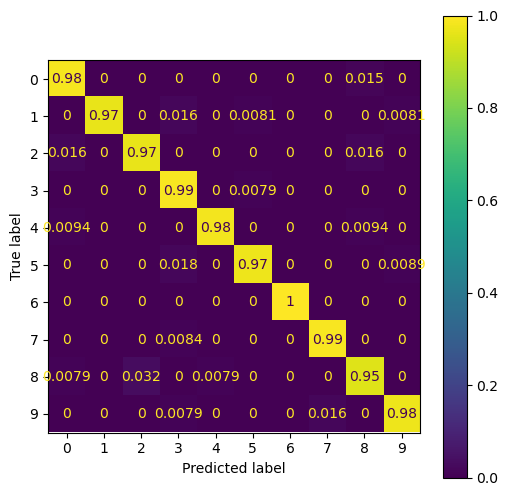

In [ ]:
epoch_cross_entropy = 0
n_examples = 0
n_correct = 0

tp_active = 0
tn_inactive = 0
fp_inact_act = 0
fn_act_inact = 0


correct = []
true_label = []
pred_label = []
index_nums = []
index_num = 0
test_output = []
test_output_probs = []

max_inds_arr_list = []
max_sims_arr_list = []
for inputs, labels in test_dataloader:
    inputs = torch.nan_to_num(inputs)
    whole.base_list[0].eval()
    for chan in range(exp_var_dict['num_channels']):
        whole.proto_list[chan].eval()
    whole.final_list[0].eval()
    with torch.no_grad():
        output, min_dist_list, scaled_sim_list = whole(inputs, False)

        # compute loss
        cross_entropy = torch.nn.functional.cross_entropy(output, labels.to(torch.long))
        test_output.append(output.data)

        probs = torch.nn.functional.softmax(output.data)
        test_output_probs.append(probs)
        predicted = torch.max(probs, 1)
        n_examples += labels.size(0)
        n_correct += torch.eq(predicted[1], labels).sum().item()

        if predicted[1] == 0 and labels != 0:
            fn_act_inact +=1
        if predicted[1] == 0 and labels == 0:
            tn_inactive +=1
        if predicted[1] != 0 and labels != 0:
            tp_active += 1
        if predicted[1] !=0 and labels == 0:
            fp_inact_act +=1

        #epoch_cross_entropy += cross_entropy.item()
        correct.append(torch.eq(predicted[1], labels).sum().item())
        true_label.append(int(labels.cpu().item()))
        pred_label.append(predicted[1].cpu().item())

        index_nums.append(index_num)
        index_num+=1

    max_inds_chan = []
    max_sims_chan = []
    for chan in range(exp_var_dict['num_channels']):
        result1 = [np.unravel_index(np.argmax(r.cpu()), r.cpu().shape) for r in scaled_sim_list[chan][0]]
        max_inds_chan.append(result1[:])

        result1 = [torch.amax(scaled_sim_list[chan], dim=(2,3)).cpu().detach().numpy()]
        max_sims_chan.append(result1[0][0][:])
    max_inds_arr_list.append(max_inds_chan)
    max_sims_arr_list.append(max_sims_chan)


acc = n_correct/n_examples
print('Testing accuracy: ' + str(acc))

cm = confusion_matrix(np.asarray(true_label), np.asarray(pred_label), normalize='true')
fig, ax = plt.subplots(figsize=(6,6))
ax = plt.gca()
disp = ConfusionMatrixDisplay(cm)
disp.plot(ax=ax)

fig.canvas.draw()  



all_loc_scale = []
all_conv_prototypes = []
all_prototype_sample_ind = []

for chan in range(exp_var_dict['num_channels']):
    all_loc_scale.append(prototype_info_list[chan][5].cpu().detach().numpy())
    all_conv_prototypes.append(prototype_info_list[chan][4])
    all_prototype_sample_ind.append(prototype_info_list[chan][0])
all_max_inds = np.asarray(max_inds_arr_list)  
all_max_sims = np.asarray(max_sims_arr_list) 



In [10]:
def plot_prototype(ind, chan_rf, input_size, axs, all_conv_prototypes, all_prototype_sample_ind, all_images, all_loc_scale, show=False, return_axes=False, save_fig=False):
    chan_num = ind // exp_var_dict['num_prototypes']
    all_num = ind % exp_var_dict['num_prototypes']

    i3 = int(all_conv_prototypes[chan_num][all_num,0])
    j3 = int(all_conv_prototypes[chan_num][all_num,1])

    proto_ind = int(all_prototype_sample_ind[chan_num][all_num]) #ind is between 1 and 40
    axs.imshow(all_images[proto_ind,chan_num,:,:], cmap='gray')
    input_mask, y1, y2, x1, x2 = output_to_input(i3,j3,chan_rf[chan_num][0], chan_rf[chan_num][1], chan_rf[chan_num][2], chan_rf[chan_num][3], input_size)

    xy = (x1, y1)
    rect = patches.Rectangle(xy , x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    axs.add_patch(rect)
    axs.set_xticks([])
    axs.set_yticks([])
    if show == True:
        if save_fig != False:
            plt.savefig("mnist_figs/"+save_fig+".pdf", format='pdf', bbox_inches='tight')
        plt.show()
    
    plt.imshow( all_loc_scale[chan_num][all_num],vmin=-1, vmax=1,cmap='RdGy')
    plt.xticks([])
    plt.yticks([])
    
    loc_axis = plt.gca()

    if save_fig != False:
        plt.savefig("mnist_figs/loc_scale_"+save_fig+".pdf", format='pdf', bbox_inches='tight')

    plt.show()

    if return_axes == True:
        return axs, loc_axis
    

Test Sample Number: 98
Winning Prototype Label: 2
Winning Prototype Number: 62
Winning Prototype Score: 3.890546
Winning Prototype Channel: 1


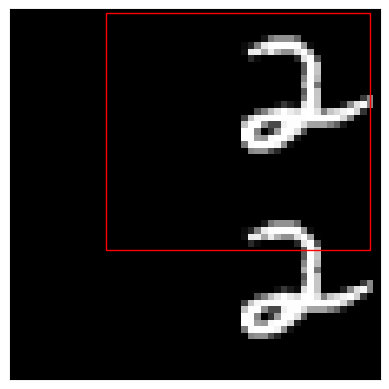

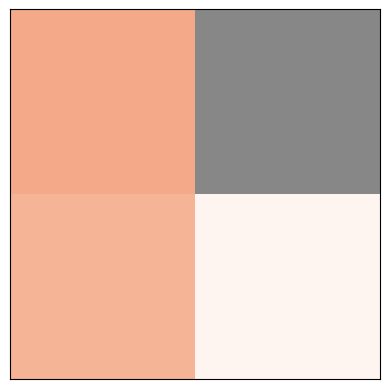

Second Winning Prototype Label: 3
Second Winning Prototype Number: 67
Second Winning Prototype Score: 3.7551672
Second Winning Prototype Channel: 1


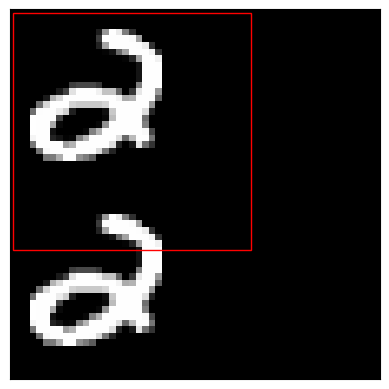

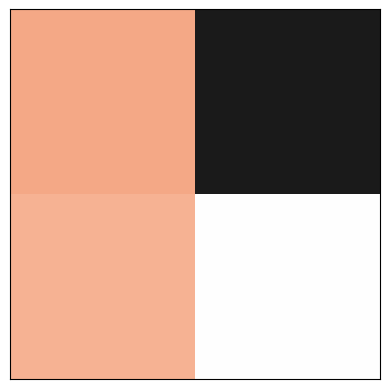

Third Winning Prototype Label: 5
Third Winning Prototype Number: 79
Third Winning Prototype Score: 3.6443024
Third Winning Prototype Channel: 1


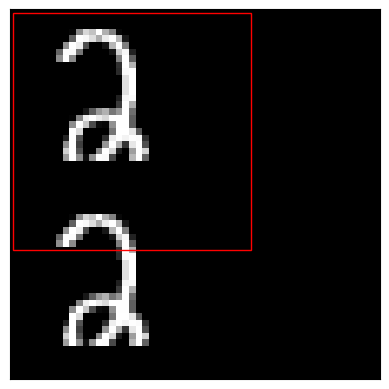

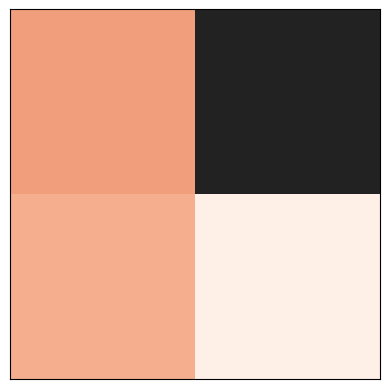

In [ ]:
plt.style.use('default')
for q in [98]:

    pred_lab = pred_label[q]
    weights = whole.final_list[0].last_layer.weight.cpu().detach().numpy()
    sim_values = all_max_sims[q,:,:].reshape(exp_var_dict['num_channels']*exp_var_dict['num_prototypes'])
    scores = sim_values * weights[pred_lab,:] #scores for predicted prototype

    scores_sort = np.argsort(scores)
    ind = scores_sort[-1]
    chan_num = ind // exp_var_dict['num_prototypes']
    all_num = ind % exp_var_dict['num_prototypes']

    proto_ind = int(all_prototype_sample_ind[chan_num][all_num])

    print('Test Sample Number: '+str(q))
    print('Winning Prototype Label: '+str(all_labels[proto_ind]))
    print('Winning Prototype Number: '+str(ind)) 
    print('Winning Prototype Score: '+str(scores[ind]))
    print('Winning Prototype Channel: '+str(chan_num))

    plot_prototype(ind, chan_rf, input_size, plt.gca(), all_conv_prototypes, all_prototype_sample_ind, all_images, all_loc_scale, show=True,save_fig = False)
    #plot_prototype(ind, chan_rf, input_size, plt.gca(), all_conv_prototypes, all_prototype_sample_ind, all_images, all_loc_scale, show=True,save_fig = 'top_98')
    ind = scores_sort[-2]
    chan_num = ind // exp_var_dict['num_prototypes']
    all_num = ind % exp_var_dict['num_prototypes']
    proto_ind = int(all_prototype_sample_ind[chan_num][all_num])
    print('Second Winning Prototype Label: '+str(all_labels[proto_ind]))
    print('Second Winning Prototype Number: '+str(ind))
    print('Second Winning Prototype Score: '+str(scores[ind]))
    print('Second Winning Prototype Channel: '+str(chan_num))

    plot_prototype(ind, chan_rf, input_size, plt.gca(), all_conv_prototypes, all_prototype_sample_ind, all_images, all_loc_scale, show=True,save_fig = False)
    #plot_prototype(ind, chan_rf, input_size, plt.gca(), all_conv_prototypes, all_prototype_sample_ind, all_images, all_loc_scale, show=True,save_fig = 'second_98')

    ind = scores_sort[-3]
    chan_num = ind // exp_var_dict['num_prototypes']
    all_num = ind % exp_var_dict['num_prototypes']
    proto_ind = int(all_prototype_sample_ind[chan_num][all_num])
    print('Third Winning Prototype Label: '+str(all_labels[proto_ind]))
    print('Third Winning Prototype Number: '+str(ind)) 
    print('Third Winning Prototype Score: '+str(scores[ind]))
    print('Third Winning Prototype Channel: '+str(chan_num))

    plot_prototype(ind, chan_rf, input_size, plt.gca(), all_conv_prototypes, all_prototype_sample_ind, all_images, all_loc_scale, show=True,save_fig = False)
    #plot_prototype(ind, chan_rf, input_size, plt.gca(), all_conv_prototypes, all_prototype_sample_ind, all_images, all_loc_scale, show=True,save_fig = 'third_98')



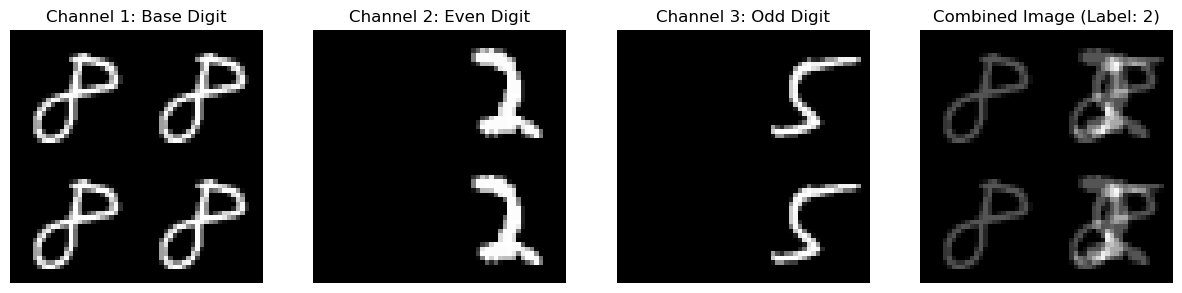

In [13]:
def visualize_synthetic_image(ch1, ch2, ch3, synthetic_image, label):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    axes[0].imshow(ch1, cmap='gray', vmin=0, vmax=1)
    axes[0].set_title("Channel 1: Base Digit")

    axes[1].imshow(ch2, cmap='gray', vmin=0, vmax=1)
    axes[1].set_title("Channel 2: Even Digit")

    axes[2].imshow(ch3, cmap='gray', vmin=0, vmax=1)
    axes[2].set_title("Channel 3: Odd Digit")

    axes[3].imshow(synthetic_image.sum(axis=0), cmap='gray', vmin=0, vmax=3)
    axes[3].set_title(f"Combined Image (Label: {label})")

    for ax in axes:
        ax.axis("off")
    #plt.savefig('mnist_figs/mnist_98bnw_sample.pdf', format='pdf', bbox_inches='tight')
    plt.show()


visualize_synthetic_image(test_images[98][0], test_images[98][1], test_images[98][2], test_images[98], 2)

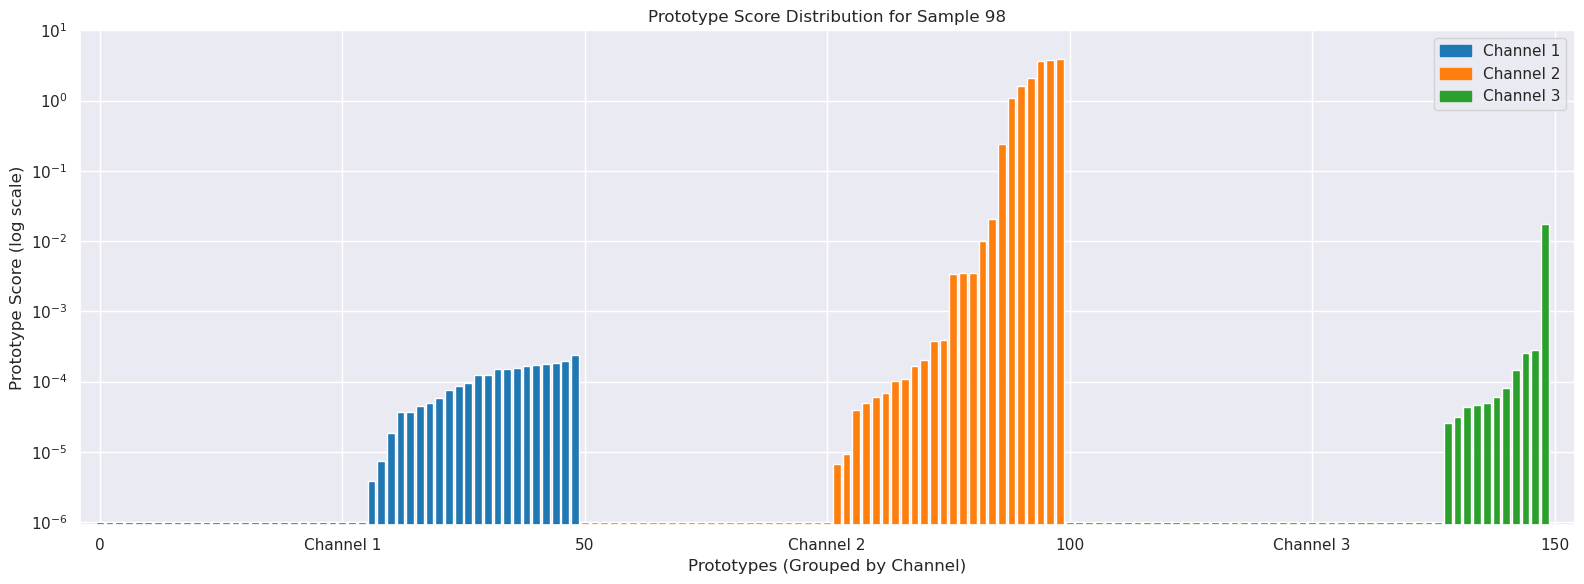

In [14]:

sns.set_theme() 

q=98
pred_lab = 2
weights = whole.final_list[0].last_layer.weight.cpu().detach().numpy()
sim_values = all_max_sims[q,:,:].reshape(exp_var_dict['num_channels']*exp_var_dict['num_prototypes'])
scores = sim_values * weights[pred_lab,:] 

groups = scores.reshape(3, 50)
groups_sorted = np.sort(groups, axis=1)
values_sorted = groups_sorted.reshape(-1)

min_nonzero = np.min(values_sorted[values_sorted > 0])
ZERO_BAR_HEIGHT = min_nonzero * 0.1
plot_vals = np.where(values_sorted < 1e-6, 1e-6, values_sorted)

group_colors = ["tab:blue", "tab:orange", "tab:green"]
colors = np.array([group_colors[0]]*50 + [group_colors[1]]*50 + [group_colors[2]]*50)
colors[values_sorted == 0] = "black"

x = np.arange(150)
fig, ax = plt.subplots(figsize=(16,6))
ax.bar(x, plot_vals, color=colors, width=0.8)
ax.set_yscale("log")
ax.set_ylim(0.9* 1e-6, 10)
ax.set_xlim(-2, 152)


xtick_positions = [0, 25, 50, 75, 100, 125, 150]
xtick_labels    = ["0", "Channel 1", "50", "Channel 2", "100", "Channel 3", "150"]

plt.xticks(xtick_positions, xtick_labels)

legend_handles = [
    Patch(color=group_colors[0], label="Channel 1"),
    Patch(color=group_colors[1], label="Channel 2"),
    Patch(color=group_colors[2], label="Channel 3"),
]
ax.legend(handles=legend_handles, loc="upper right")

ax.set_xlabel("Prototypes (Grouped by Channel)")
ax.set_ylabel("Prototype Score (log scale)")
ax.set_title("Prototype Score Distribution for Sample 98")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.tight_layout()

#plt.savefig('mnist_figs/mnist_98_150scores.svg', format='svg', bbox_inches='tight')
plt.show()


/tmp/ipykernel_2877747/1315186338.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


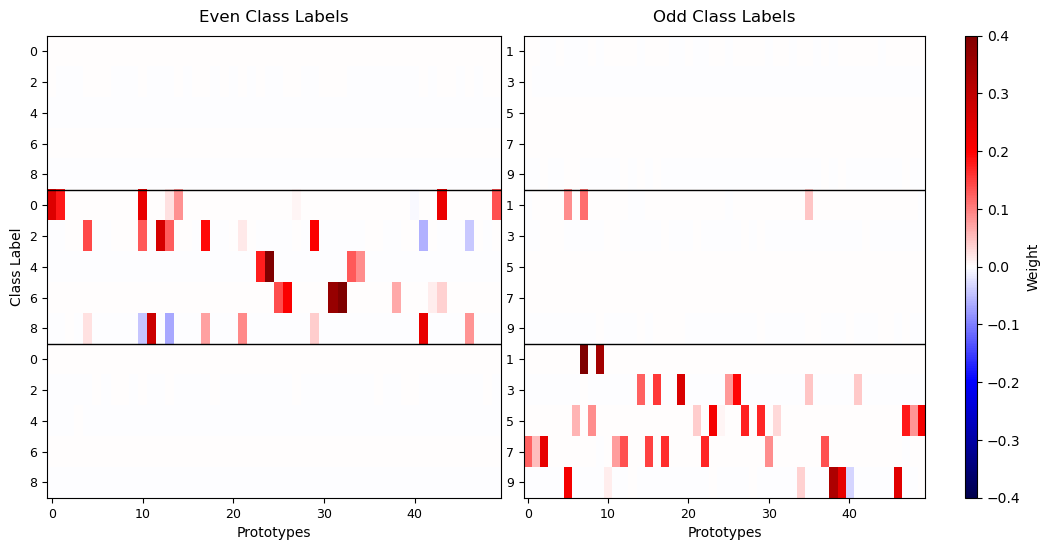

In [17]:
sns.reset_defaults()
plt.style.use('default')
plt.rcdefaults()


weights = whole.final_list[0].last_layer.weight.cpu().detach().numpy() 
groups = scores.reshape(3, 10, 5)
plot_groups = []

for subgroup in range(10):

    grp = groups[:,subgroup,:].flatten()  

    sorted_grp = np.concatenate([np.sort(grp[i*5:(i+1)*5]) for i in range(3)])
    plot_groups.append(sorted_grp)

values_sorted = np.concatenate(plot_groups)
data = weights
blocks = np.hsplit(data, exp_var_dict['num_channels']) 
stacked_data = np.vstack(blocks)

num_channels = exp_var_dict['num_channels']  
rows_per_channel = 10  

class_labels = np.tile(np.arange(rows_per_channel), num_channels)
even_mask = class_labels % 2 == 0
odd_mask  = class_labels % 2 == 1

even_data   = stacked_data[even_mask]
odd_data    = stacked_data[odd_mask]

fig = plt.figure(figsize=(12, 6))  
gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[20, 20], wspace=0.05)

ax_even = fig.add_subplot(gs[0, 0])
ax_odd  = fig.add_subplot(gs[0, 1])  

norm = matplotlib.colors.TwoSlopeNorm(vmin=-0.4, vcenter=0, vmax=0.4)


im_even = ax_even.imshow(even_data, cmap="seismic", norm=norm, aspect='auto')
ax_even.set_title("Even Class Labels", fontsize=12, pad=10)
ax_even.set_ylabel("Class Label", fontsize=10)


even_labels = np.arange(0, rows_per_channel, 2)
yticks_even = []
yticklabels_even = []
for ch in range(num_channels):
    start = ch * (rows_per_channel // 2)
    for i, label in enumerate(even_labels):
        yticks_even.append(start + i)
        yticklabels_even.append(label)

ax_even.set_yticks(yticks_even)
ax_even.set_yticklabels(yticklabels_even, fontsize=9)


N = even_data.shape[1]
xticks = np.arange(0, N, 10)
ax_even.set_xticks(xticks)
ax_even.set_xticklabels(xticks, fontsize=9)
ax_even.set_xlabel("Prototypes", fontsize=10)

for ch in range(1, num_channels):
    ax_even.axhline(ch * (rows_per_channel // 2) - 0.5, color='black', linewidth=1)

im_odd = ax_odd.imshow(odd_data, cmap="seismic", norm=norm, aspect='auto')
ax_odd.set_title("Odd Class Labels", fontsize=12, pad=10)

odd_labels = np.arange(1, rows_per_channel, 2)
yticks_odd = []
yticklabels_odd = []
for ch in range(num_channels):
    start = ch * (rows_per_channel // 2)
    for i, label in enumerate(odd_labels):
        yticks_odd.append(start + i)
        yticklabels_odd.append(label)

ax_odd.set_yticks(yticks_odd)
ax_odd.set_yticklabels(yticklabels_odd, fontsize=9)
ax_odd.set_xlabel("Prototypes", fontsize=10)
ax_odd.set_xticks(xticks)
ax_odd.set_xticklabels(xticks, fontsize=9)


for ch in range(1, num_channels):
    ax_odd.axhline(ch * (rows_per_channel // 2) - 0.5, color='black', linewidth=1)


divider = make_axes_locatable(ax_odd)
cax = divider.append_axes("right", size="3%", pad=0.4) 
cbar = fig.colorbar(im_even, cax=cax)
cbar.set_label("Weight", fontsize=10)

plt.tight_layout()

#plt.savefig("paper_figs/mnist_weights.pdf", format="pdf",bbox_inches='tight')
plt.show()


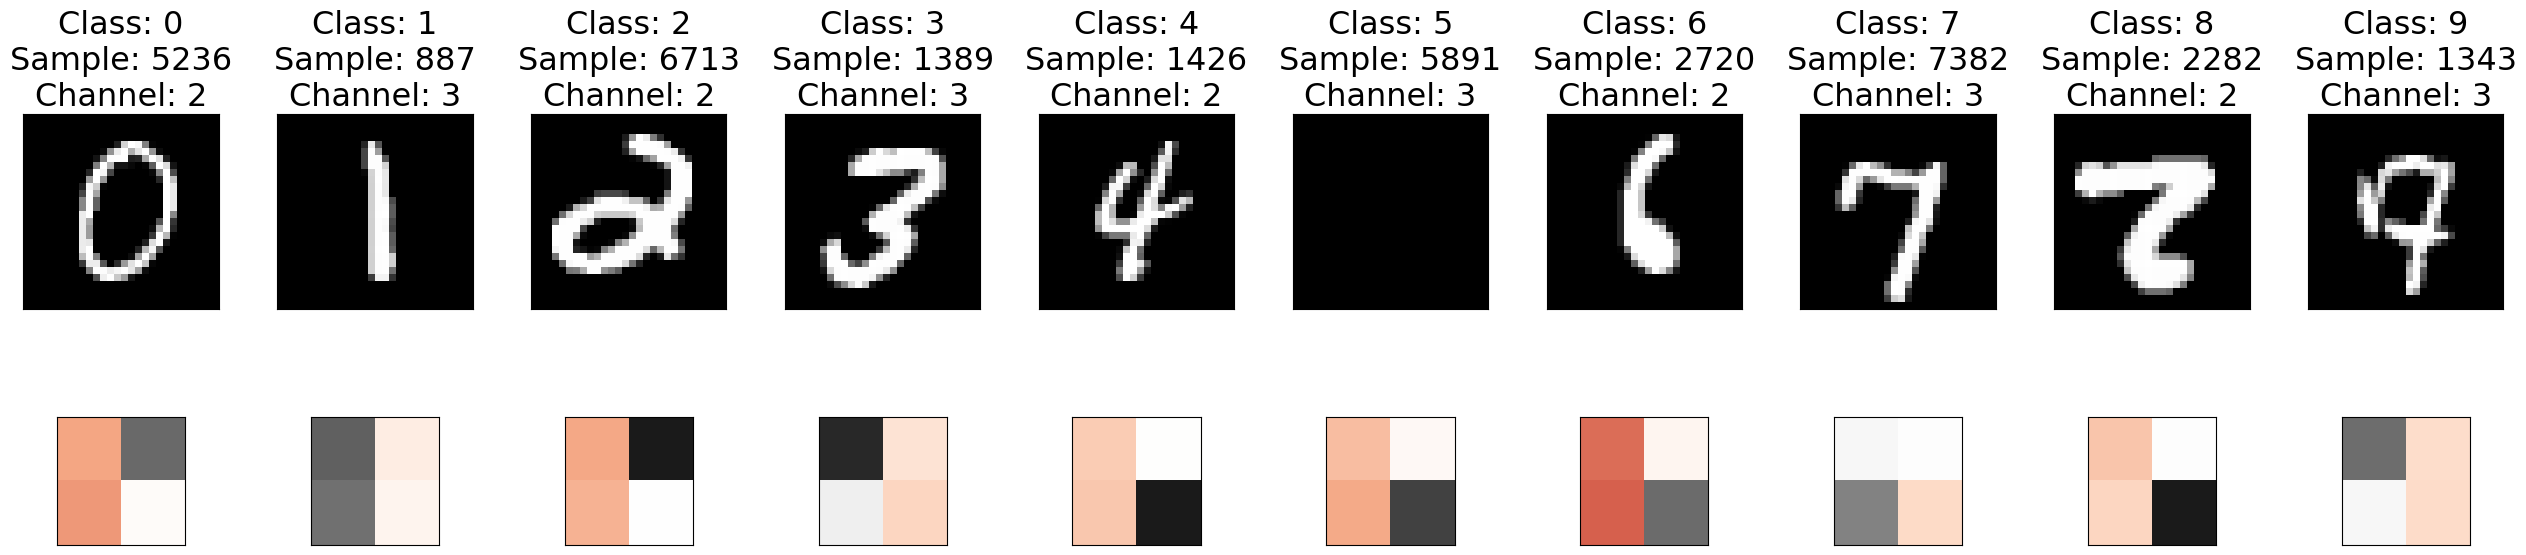

In [21]:

all_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes']))
correct_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes'])) 
correct1_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes'])) 
incorrect_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes']))

plt.style.use('default') 


fig, axs = plt.subplots(
    2, 10, figsize=(32,6),
    gridspec_kw={'height_ratios': [1, 0.5]} 
)
for class_label in range(0,10):
    proto_ind_count = []
    for q in range(len(test_images)):
        if correct[q] == 1 and pred_label[q] == class_label:
            pred_lab = pred_label[q]
            weights = whole.final_list[0].last_layer.weight.cpu().detach().numpy()
            sim_values = all_max_sims[q,:,:].reshape(exp_var_dict['num_channels']*exp_var_dict['num_prototypes'])
            scores = sim_values * weights[pred_lab,:] #scores for predicted prototype

            scores_sort = np.argsort(scores)
            ind1 = scores_sort[-1]
            chan_num = ind1 // exp_var_dict['num_prototypes']
            all_num = ind1 % exp_var_dict['num_prototypes']

            proto_ind = int(all_prototype_sample_ind[chan_num][all_num])
            proto_ind_count.append(ind1)
            if correct[q] == 1:
                correct_overall_prototype_winning_count[chan_num][all_num] += 1
                if int(all_labels[proto_ind]) == int(true_label[q]):
                    correct1_overall_prototype_winning_count[chan_num][all_num] += 1
            else:
                incorrect_overall_prototype_winning_count[chan_num][all_num] +=1

    ind = mode(proto_ind_count)

    chan_num = ind // exp_var_dict['num_prototypes']
    all_num = ind % exp_var_dict['num_prototypes']

    i3 = int(all_conv_prototypes[chan_num][all_num,0])
    j3 = int(all_conv_prototypes[chan_num][all_num,1])

    proto_ind = int(all_prototype_sample_ind[chan_num][all_num]) 
    input_mask, y1, y2, x1, x2 = output_to_input(i3,j3,chan_rf[chan_num][0], chan_rf[chan_num][1], chan_rf[chan_num][2], chan_rf[chan_num][3], input_size)

    xy = (x1, y1)
    rect = patches.Rectangle(xy , x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    axs[0, class_label].set_xticks([])
    axs[0, class_label].set_yticks([])
    axs[0, class_label].set_title("Class: "+str(class_label)+"\nSample: " +str(proto_ind)+"\nChannel: "+str(chan_num+1), fontsize=23)

    row1 = 56 - y2  
    row2 = 56 - y1
    col1 = x1
    col2 = x2

    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2

    if cx < 28 and cy < 28:
        quadrant = 2 
    elif cx >= 28 and cy < 28:
        quadrant = 3  
    elif cx < 28 and cy >= 28:
        quadrant = 0  
    else:
        quadrant = 1  

    if quadrant == 0:      
        x_slice = slice(0, 28)
        y_slice = slice(0, 28)
    elif quadrant == 1:   
        x_slice = slice(0, 28)
        y_slice = slice(28, 56)
    elif quadrant == 2:     
        x_slice = slice(28, 56)
        y_slice = slice(0, 28)
    else:                  
        x_slice = slice(28, 56)
        y_slice = slice(28, 56)

    axs[0, class_label].imshow(all_images[proto_ind,chan_num,x_slice,y_slice], cmap='gray')
    axs[1, class_label].imshow( all_loc_scale[chan_num][all_num],vmin=-1, vmax=1,cmap='RdGy')
    axs[1, class_label].set_xticks([])
    axs[1, class_label].set_yticks([])

    ax = axs[1, class_label]
    pos = ax.get_position()  
    new_height = pos.height
    new_bottom = pos.y0 + (0.5 * (0.5 - new_height)) 
    ax.set_position([pos.x0, new_bottom, pos.width, new_height])
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

plt.show()

#plt.savefig("mnist_figs/mnist_freqproto_crop.pdf", format="pdf",bbox_inches='tight')
